In [16]:
# Import Libraries
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import pickle

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# Sklearn and Imbalanced-learn Libraries
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV, VarianceThreshold, mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, balanced_accuracy_score,
    classification_report
)
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.utils import resample
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE




from sklearn.base import BaseEstimator, TransformerMixin

# Additional Libraries
from sklearn.base import clone
from sklearn.exceptions import NotFittedError
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries with GPU Support
import xgboost as xgb
import lightgbm as lgb

# For SHAP values
import shap

# Statistical Tests
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp

# For progress monitoring
from tqdm import tqdm
from kneed import KneeLocator


import warnings

# Suppress warnings to reduce clutter
warnings.filterwarnings('ignore')

from sklearn.exceptions import ConvergenceWarning

# Suppress ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from joblib import Parallel, delayed
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import mannwhitneyu
import numpy as np
import pandas as pd

# Necessary imports
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
from sklearn.utils.validation import check_X_y, check_array
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')



In [2]:
# File paths
clinical_data_path = '/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/Clinical_and_Other_Features_final_comb.xlsx'
features_path = '/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/features_extracted_VGG16.pkl.gz'

In [3]:
#Function: Load and Process Data
def load_clinical_data(clinical_data_path):
    """
    Loads and preprocesses clinical data from an Excel file.

    Parameters:
    - clinical_data_path (str): Path to the clinical data Excel file.

    Returns:
    - pd.DataFrame: Preprocessed clinical data.
    """
    print("Loading clinical data...")
    clinical_data = pd.read_excel(clinical_data_path)

    # Rename columns for consistency
    clinical_data.columns = [col.replace(' ', '_') for col in clinical_data.columns]
    clinical_data = clinical_data.rename(
        columns={
            'Patient_ID': 'patient_id',
            'Pathologic_Response_to_Neoadjuvant_Therapy': 'response'
        }
    )

    # Convert 'Breast_MRI_001' to '001' in the patient_id column
    clinical_data['patient_id'] = clinical_data['patient_id'].apply(
        lambda x: x.split('_')[-1] if isinstance(x, str) else x
    )

    # Convert response to binary: 1 means pCR, else non-pCR
    clinical_data['response'] = clinical_data['response'].apply(
        lambda x: 1 if x == 1 else 0
    )

    # Preprocess clinical data
    clinical_data['patient_id'] = clinical_data['patient_id'].astype(str)

    # Separate numerical and categorical columns
    patient_id_cols = ["patient_id"]
    response_cols = ["response"]
    numerical_cols = ["Date_of_Birth"]  # Consider converting to 'Age at Diagnosis'
    categorical_cols = clinical_data.columns[
        (clinical_data.columns != "Date_of_Birth") &
        (clinical_data.columns != "patient_id") &
        (clinical_data.columns != "response")
    ]

    numerical_df = clinical_data[numerical_cols]
    patient_id_df = clinical_data[patient_id_cols]
    response_df = clinical_data[response_cols]

    # One-hot encode categorical columns
    clinical_data[categorical_cols] = clinical_data[categorical_cols].astype('category')
    categorical_df = pd.get_dummies(clinical_data[categorical_cols], drop_first=True)
    categorical_df = categorical_df.astype(int)

    # Concatenate all dataframes
    encoded_df = pd.concat(
        [patient_id_df, numerical_df, categorical_df, response_df],
        axis=1
    )

    print("Clinical data loaded and processed.")
    return encoded_df

def load_image_features(features_path):
    """
    Loads and processes image features from a compressed pickle file.

    Parameters:
    - features_path (str): Path to the compressed pickle file containing image features.

    Returns:
    - pd.DataFrame: Processed image features.
    """
    print("Loading image features...")
    with gzip.open(features_path, 'rb') as f:
        features_dict = pickle.load(f)

    # Extract patient IDs and features
    features_data = {
        'patient_id': [key.split('-')[0] for key in features_dict.keys()],
        **{
            f'feature_{i}': [features_dict[key][i] for key in features_dict.keys()]
            for i in range(len(next(iter(features_dict.values()))))
        }
    }

    # Create a DataFrame
    features_df = pd.DataFrame(features_data)
    features_df['patient_id'] = features_df['patient_id'].astype(str)
    print("Image features loaded.")
    return features_df


def load_and_preprocess_data(clinical_data_path, features_path):
    clinical_data_processed = load_clinical_data(clinical_data_path)
    features_df = load_image_features(features_path)
    clinical_data_processed['patient_id'] = clinical_data_processed['patient_id'].astype(str)
    features_df['patient_id'] = features_df['patient_id'].astype(str)

    # Prepare three variations of the dataset
    print("Preparing dataset variations...")

    datasets = {}

    # Handle missing data in image features
    print("Imputing missing values in image features...")
    imputer = SimpleImputer(strategy='mean')
    features_df_imputed = imputer.fit_transform(features_df.drop(columns=['patient_id']))

    # Feature scaling
    print("Scaling image features...")
    scaler = MinMaxScaler()
    features_df_scaled = scaler.fit_transform(features_df_imputed)

    # Create a DataFrame for scaled features
    features_scaled_df = pd.DataFrame(features_df_scaled, columns=[f'feature_{i}' for i in range(features_df_scaled.shape[1])])
    features_scaled_df['patient_id'] = features_df['patient_id'].values

    # Now, merge scaled image features with clinical data
    data_scaled = features_scaled_df.merge(
        clinical_data_processed,
        on='patient_id',
        how='inner'
    ).reset_index(drop=True)

    # 1. Image Features (Scaled)
    image_feature_columns = [col for col in data_scaled.columns if 'feature_' in col]

    X_image = data_scaled[image_feature_columns]
    y_image = data_scaled['response'].astype(int)
    groups_image = data_scaled['patient_id']

    # 2. Clinical Features
    # Subset clinical data to include only patients present in data_scaled
    patient_ids_in_data_scaled = clinical_data_processed['patient_id'].isin(data_scaled['patient_id'])
    clinical_data_in_data_scaled = clinical_data_processed[patient_ids_in_data_scaled].reset_index(drop=True)

    X_clinical = clinical_data_in_data_scaled.drop(columns=['patient_id', 'response'])
    y_clinical = clinical_data_in_data_scaled['response'].astype(int)
    groups_clinical = clinical_data_in_data_scaled['patient_id']

    # 3. Combined Features (Scaled image features + clinical data)
    # Exclude 'patient_id' and 'response' from features
    exclude_columns = ['patient_id', 'response']
    X_combined = data_scaled.drop(columns=exclude_columns)
    y_combined = data_scaled['response'].astype(int)
    groups_combined = data_scaled['patient_id']

    # Preprocess each dataset variation
    def preprocess_data(X):
        # Remove features with zero variance
        variance_threshold = VarianceThreshold(threshold=0)
        X_var = variance_threshold.fit_transform(X)
        feature_names = X.columns[variance_threshold.get_support(indices=True)]
        X = pd.DataFrame(X_var, columns=feature_names)
        return X

    X_combined = preprocess_data(X_combined)
    X_clinical = preprocess_data(X_clinical)
    X_image = preprocess_data(X_image)

    datasets['Combined'] = (X_combined, y_combined, groups_combined)
    datasets['Clinical'] = (X_clinical, y_clinical, groups_clinical)
    datasets['Image'] = (X_image, y_image, groups_image)

    return datasets


In [4]:
# Load and preprocess the data
data_variations = load_and_preprocess_data(clinical_data_path, features_path)

Loading clinical data...
Clinical data loaded and processed.
Loading image features...
Image features loaded.
Preparing dataset variations...
Imputing missing values in image features...
Scaling image features...


In [5]:
#Data Train Test Split
def stratified_group_split(X, y, groups, test_size=0.2, random_state=None):
    # Create a DataFrame with groups and their corresponding class labels
    group_df = pd.DataFrame({'group': groups, 'label': y})
    group_df = group_df.drop_duplicates()

    # Perform stratified split on groups
    stratify = group_df['label']
    group_train, group_test = train_test_split(
        group_df['group'], test_size=test_size, random_state=random_state, stratify=stratify
    )

    # Select samples based on group splits
    train_idx = X[groups.isin(group_train)].index
    test_idx = X[groups.isin(group_test)].index

    return train_idx, test_idx

# Usage
data_splits = {}

for dataset_name, (X_full, y_full, groups) in data_variations.items():
    print(f"\nProcessing {dataset_name} Dataset")

    # Ensure groups is a pandas Series with reset index
    groups = pd.Series(groups).reset_index(drop=True)
    y_full_series = pd.Series(y_full).reset_index(drop=True)
    X_full = X_full.reset_index(drop=True)

    train_idx, test_idx = stratified_group_split(X_full, y_full_series, groups, test_size=0.2, random_state=42)

    X_train_full = X_full.loc[train_idx].reset_index(drop=True)
    y_train_full = y_full_series.loc[train_idx].reset_index(drop=True)
    X_test_full = X_full.loc[test_idx].reset_index(drop=True)
    y_test = y_full_series.loc[test_idx].reset_index(drop=True)

    # Retrieve patient IDs for train and test sets
    patient_ids_train = groups.loc[train_idx].reset_index(drop=True)
    patient_ids_test = groups.loc[test_idx].reset_index(drop=True)

    data_splits[dataset_name] = {
        'X_train_full': X_train_full,
        'X_test_full': X_test_full,
        'y_train_full': y_train_full,
        'y_test': y_test,
        'patient_ids_train': patient_ids_train,
        'patient_ids_test': patient_ids_test
    }

    # Verify class distribution
    print("Training set class distribution:")
    print(y_train_full.value_counts(normalize=True))
    print("Test set class distribution:")
    print(y_test.value_counts(normalize=True))


Processing Combined Dataset
Training set class distribution:
response
0    0.792833
1    0.207167
Name: proportion, dtype: float64
Test set class distribution:
response
0    0.759479
1    0.240521
Name: proportion, dtype: float64

Processing Clinical Dataset
Training set class distribution:
response
0    0.770335
1    0.229665
Name: proportion, dtype: float64
Test set class distribution:
response
0    0.773585
1    0.226415
Name: proportion, dtype: float64

Processing Image Dataset
Training set class distribution:
response
0    0.792833
1    0.207167
Name: proportion, dtype: float64
Test set class distribution:
response
0    0.759479
1    0.240521
Name: proportion, dtype: float64


In [6]:
#Function: MannWhitney & RFECV Feature Selection
class MannWhitneyUTestFeatureSelector(BaseEstimator, TransformerMixin):
    """
    Custom transformer for feature selection using the Mann-Whitney U test
    with Bonferroni correction and optional parallelization.
    """
    def __init__(self, alpha=0.05, bonferroni=True, n_jobs=-1):
        """
        Initialize the selector.

        Parameters:
        - alpha (float): The significance level for the Mann-Whitney U test.
        - bonferroni (bool): Whether to apply Bonferroni correction.
        - n_jobs (int): The number of jobs to run in parallel (default is -1, using all available cores).
        """
        self.alpha = alpha
        self.bonferroni = bonferroni
        self.n_jobs = n_jobs
        self.selected_features_ = None

    def _perform_test(self, col, X, y):
        """
        Helper function to perform Mann-Whitney U test on a single feature.
        """
        group0 = X.loc[y == 0, col]
        group1 = X.loc[y == 1, col]
        try:
            _, p = mannwhitneyu(group0, group1, alternative='two-sided')
        except ValueError:
            p = 1  # Assign high p-value if test fails
        return p

    def fit(self, X, y):
        """
        Fit the selector to the data by performing the Mann-Whitney U test for each feature.
        
        Parameters:
        - X (pd.DataFrame): The input feature matrix.
        - y (pd.Series): The target variable.
        
        Returns:
        - self: The fitted selector.
        """
        # Ensure X is a DataFrame and y is a Series with matching indices
        X = pd.DataFrame(X)
        y = pd.Series(y, index=X.index)
        
        # Parallelized Mann-Whitney U tests
        p_values = Parallel(n_jobs=self.n_jobs)(
            delayed(self._perform_test)(col, X, y) for col in X.columns
        )
        
        self.p_values_ = np.array(p_values)
        
        # Apply Bonferroni correction if needed
        if self.bonferroni:
            corrected_alpha = self.alpha / X.shape[1]  # Adjust alpha by number of tests
        else:
            corrected_alpha = self.alpha

        # Select features with p-values below the corrected alpha level
        self.selected_features_ = X.columns[self.p_values_ < corrected_alpha]
        
        return self

    def transform(self, X):
        """
        Transform the data by selecting the features that passed the Mann-Whitney U test.

        Parameters:
        - X (pd.DataFrame): The input feature matrix.

        Returns:
        - pd.DataFrame: The selected feature matrix.
        """
        # Ensure X is a DataFrame
        X = pd.DataFrame(X)
        return X.loc[:, self.selected_features_]
    
def manual_rfecv(X, y, estimator, cv, scoring='f1', min_features_to_select=5, step=0.1,  early_stopping_rounds=3):
    """
    Manually performs Recursive Feature Elimination with Cross-Validation (RFECV)
    using the specified estimator and cross-validation strategy.
    
    Parameters:
    - X (pd.DataFrame): Feature matrix.
    - y (pd.Series): Target vector.
    - estimator: The machine learning estimator to use for feature selection.
    - cv: Cross-validation strategy.
    - scoring (str): Scoring metric (default is 'f1').
    - min_features_to_select (int): Minimum number of features to select.
    - step (float): Proportion of features to remove at each iteration.
    
    Returns:
    - best_features (list): The list of best selected features based on cross-validation score.
    - history (pd.DataFrame): History of number of features and corresponding CV scores.
    """
    
    n_features = X.shape[1]
    step_num = int(max(1, step * n_features))  # Convert the step percentage to an absolute number of features
    
    # History to keep track of scores, feature sets and feature counts
    history = []
    feature_sets = []
    
    # Copy X to avoid modifying the original dataframe
    X_remaining = X.copy()

    # Early stopping tracking
    no_improvement_rounds = 0
    best_score = -np.inf
    
    while X_remaining.shape[1] > min_features_to_select:
        print(f"Evaluating with {X_remaining.shape[1]} features...")
        n_features_remaining = X_remaining.shape[1]
        step_num = int(max(1, step * n_features_remaining)) 
        
        # Perform cross-validation with the current set of features
        scores = cross_val_score(estimator, X_remaining, y, cv=cv, scoring=scoring, n_jobs=-1)
        avg_score = np.mean(scores)
        
        # Append results to the history and store the current feature set
        history.append((X_remaining.shape[1], round(avg_score, 2)))  # Round CV score to 3 decimal places
        feature_sets.append(X_remaining.columns.tolist())
        
        # Early stopping check
        if avg_score > best_score:
            best_score = avg_score
            no_improvement_rounds = 0
        else:
            no_improvement_rounds += 1
        
        if no_improvement_rounds >= early_stopping_rounds:
            print("Early stopping, no significant improvement.")
            break
        
        # Train the model and get feature importances
        estimator.fit(X_remaining, y)
        importances = estimator.feature_importances_
        
        # Create a DataFrame of features and importances
        feature_importances = pd.DataFrame({
            'feature': X_remaining.columns,
            'importance': importances
        })
        
        # Sort features by importance
        feature_importances.sort_values(by='importance', ascending=True, inplace=True)
        
        # Remove the least important features based on step size
        n_to_remove = min(step_num, X_remaining.shape[1] - min_features_to_select)
        features_to_remove = feature_importances.head(n_to_remove)['feature'].tolist()
        
        # Drop the least important features
        X_remaining.drop(columns=features_to_remove, inplace=True)
    
    # Convert history to a DataFrame for easy access
    history_df = pd.DataFrame(history, columns=['n_features', 'cv_score'])
    
    # Identify the best cross-validation score and the corresponding feature sets with the least number of features
    max_score = history_df['cv_score'].max()
    best_idx = history_df[history_df['cv_score'] == max_score]['n_features'].idxmin()  # Minimize the number of features
    
    # The best selected features correspond to the maximum cross-validation score with the least features
    best_features = feature_sets[best_idx]
    
    return best_features, history_df


Starting feature selection for Combined Dataset

Handling missing data with SimpleImputer...

Scaling features with MinMaxScaler...

Applying SMOTE to balance the classes...
Number of samples after SMOTE: 10930
Class distribution after SMOTE: 
response
0    5465
1    5465
Name: count, dtype: int64

Performing L1-based feature selection...
Number of features after L1-based selection: 100

Performing Mann-Whitney U Test feature selection with Bonferroni correction and parallelization...
Number of features after Mann-Whitney U Test: 80
Evaluating with 80 features...
Evaluating with 72 features...
Evaluating with 65 features...
Evaluating with 59 features...
Evaluating with 54 features...
Evaluating with 49 features...
Evaluating with 45 features...
Evaluating with 41 features...
Evaluating with 37 features...
Evaluating with 34 features...
Evaluating with 31 features...
Early stopping, no significant improvement.
Best Features: ['feature_3067', 'feature_4706', 'feature_5415', 'feature_76

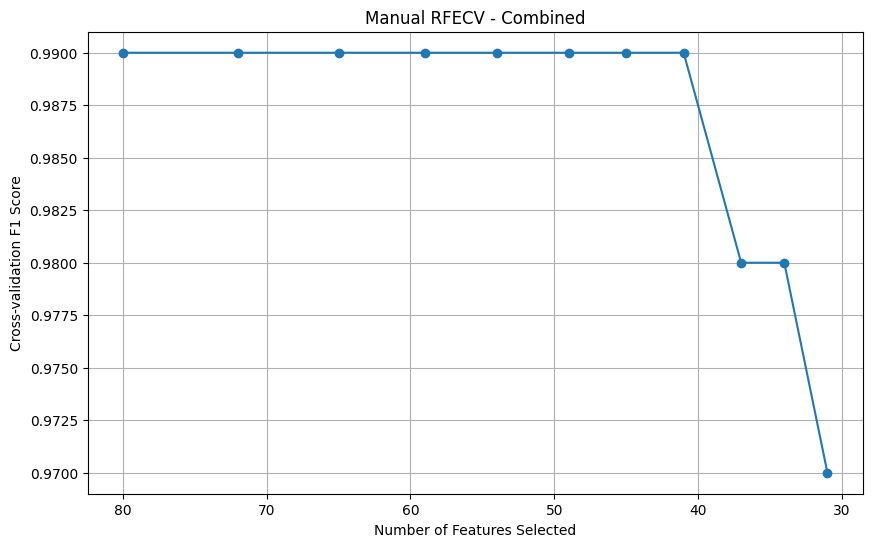


Selecting the final features from the original datasets...

Final datasets for 'Combined' stored with selected features.

Starting feature selection for Clinical Dataset

Skipping feature selection for 'Clinical' dataset. Retaining all original features.

Starting feature selection for Image Dataset

Handling missing data with SimpleImputer...

Scaling features with MinMaxScaler...

Applying SMOTE to balance the classes...
Number of samples after SMOTE: 10930
Class distribution after SMOTE: 
response
0    5465
1    5465
Name: count, dtype: int64

Performing L1-based feature selection...
Number of features after L1-based selection: 100

Performing Mann-Whitney U Test feature selection with Bonferroni correction and parallelization...
Number of features after Mann-Whitney U Test: 84
Evaluating with 84 features...
Evaluating with 76 features...
Evaluating with 69 features...
Evaluating with 63 features...
Evaluating with 57 features...
Evaluating with 52 features...
Evaluating with 47 fe

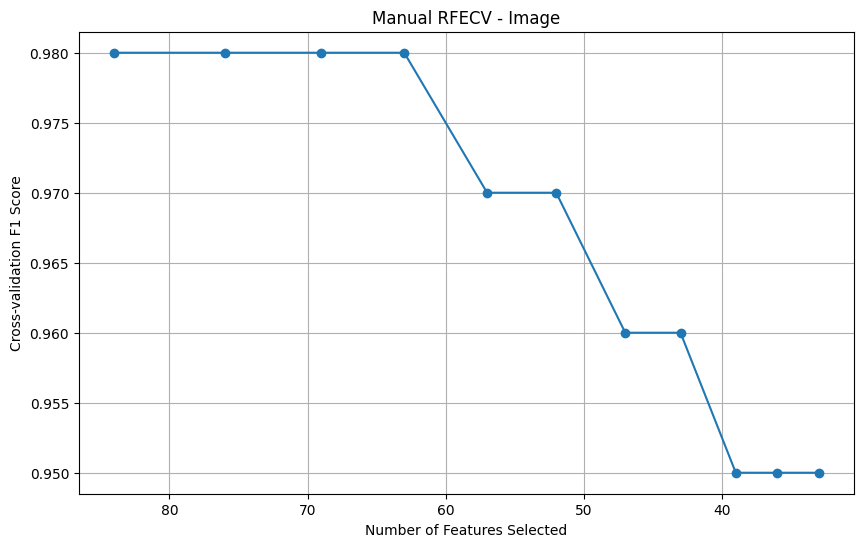


Selecting the final features from the original datasets...

Final datasets for 'Image' stored with selected features.


In [7]:
#Feature Selection
selected_features_dict = {}

apply_smote = True  # Set to False if you want to skip SMOTE
apply_mannwhitney = True  # Set to False if you want to skip Mann-Whitney U Test

for dataset_name in data_variations.keys():
    
    print(f"\nStarting feature selection for {dataset_name} Dataset")

    if dataset_name == 'Clinical':
        print("\nSkipping feature selection for 'Clinical' dataset. Retaining all original features.")
    else:
        # Retrieve data
        data = data_splits[dataset_name]

        X_train_full = data['X_train_full']
        y_train_full = data['y_train_full']
        X_test_full = data['X_test_full']
        y_test = data['y_test']
        patient_ids_train = data['patient_ids_train']  # Preserving patient IDs
        patient_ids_test = data['patient_ids_test']

        # Handle Missing Data - Imputation
        print("\nHandling missing data with SimpleImputer...")
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train_full)
        X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train_full.columns, index=X_train_full.index)

        # Feature Scaling using MinMaxScaler
        print("\nScaling features with MinMaxScaler...")
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_full.columns, index=X_train_full.index)

        if apply_smote:
            # Apply SMOTE to balance the classes in the training data
            print("\nApplying SMOTE to balance the classes...")
            smote = SMOTE(random_state=42)
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train_full)

            # Convert resampled data back to DataFrame with the original column names and reset indices
            X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train_scaled.columns)
            y_train_resampled = pd.Series(y_train_resampled)
            print(f"Number of samples after SMOTE: {X_train_resampled.shape[0]}")
            print(f"Class distribution after SMOTE: \n{y_train_resampled.value_counts()}")

            # Reset indices to ensure consistency
            X_train_l1 = X_train_resampled.reset_index(drop=True)
            y_train_resampled = y_train_resampled.reset_index(drop=True)
        else:
            print("\nSkipping SMOTE. Using original training data.")
            X_train_l1 = X_train_scaled
            y_train_resampled = y_train_full

        # L1-based Feature Selection
        print("\nPerforming L1-based feature selection...")
        l1_selector = SelectFromModel(
            LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=1000), max_features=100
        )
        l1_selector.fit(X_train_l1, y_train_resampled)
        X_train_l1 = l1_selector.transform(X_train_l1)
        X_train_l1 = pd.DataFrame(X_train_l1, columns=X_train_resampled.columns[l1_selector.get_support()])
        print(f"Number of features after L1-based selection: {X_train_l1.shape[1]}")

        if apply_mannwhitney:
            # Mann-Whitney U Test Feature Selection with Parallelization
            print("\nPerforming Mann-Whitney U Test feature selection with Bonferroni correction and parallelization...")
            mannwhitney_selector = MannWhitneyUTestFeatureSelector(alpha=0.05, bonferroni=True, n_jobs=-1)
            mannwhitney_selector.fit(X_train_l1, y_train_resampled)
            X_train_mwu = mannwhitney_selector.transform(X_train_l1)
            print(f"Number of features after Mann-Whitney U Test: {X_train_mwu.shape[1]}")
        else:
            print("\nSkipping Mann-Whitney U Test. Using L1-selected features.")
            X_train_mwu = X_train_l1

        # Manually perform RFECV using a Random Forest Classifier
        rf_estimator = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=50, max_depth=7)
        cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # Perform manual RFECV
        best_features, rfecv_history = manual_rfecv(
            X_train_mwu, y_train_resampled, rf_estimator, cv_strategy,
            scoring='f1', min_features_to_select=5, step=0.1, early_stopping_rounds=10
        )

        print(f"Best Features: {best_features}")
        print(rfecv_history)

        # Plot the number of features vs. cross-validation score
        plt.figure(figsize=(10, 6))
        plt.plot(rfecv_history['n_features'], rfecv_history['cv_score'], marker='o')
        plt.xlabel("Number of Features Selected")
        plt.ylabel("Cross-validation F1 Score")
        plt.title(f"Manual RFECV - {dataset_name}")
        plt.gca().invert_xaxis()  # Optional: Invert x-axis to show decreasing number of features
        plt.grid(True)
        plt.show()

        # Store the selected features
        selected_features = best_features
        selected_features_dict[dataset_name] = selected_features

        # Select the final features from the original datasets
        print("\nSelecting the final features from the original datasets...")

        # Ensure that all selected features exist in the original datasets
        missing_in_train = set(selected_features) - set(X_train_full.columns)
        missing_in_test = set(selected_features) - set(X_test_full.columns)
        if missing_in_train:
            raise ValueError(f"The following selected features are missing in X_train_full: {missing_in_train}")
        if missing_in_test:
            raise ValueError(f"The following selected features are missing in X_test_full: {missing_in_test}")

        # Subset the original X_train_full and X_test_full to include only the selected features
        X_train_final = X_train_full[selected_features].copy()
        X_test_final = X_test_full[selected_features].copy()

        # Reset indices to ensure consistency
        X_train_final.reset_index(drop=True, inplace=True)
        y_train_full = y_train_full.reset_index(drop=True)
        X_test_final.reset_index(drop=True, inplace=True)
        y_test = y_test.reset_index(drop=True)

        # Verify that the number of features matches
        assert X_train_final.shape[1] == X_test_final.shape[1], "Mismatch in number of features between training and test sets."
        assert X_train_final.shape[0] == y_train_full.shape[0], "Mismatch in number of rows between training X and Y."
        assert X_test_final.shape[0] == y_test.shape[0], "Mismatch in number of rows between test X and Y."

        # Store the final datasets with selected features in data_splits
        data_splits[dataset_name] = {
            'X_train_full': X_train_final,
            'X_test_full': X_test_final,
            'y_train_full': y_train_full,
            'y_test': y_test,
            'patient_ids_train': patient_ids_train,  # Preserve patient IDs
            'patient_ids_test': patient_ids_test
        }

        print(f"\nFinal datasets for '{dataset_name}' stored with selected features.")

In [29]:
# Define classifiers and param grid to evaluate
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='liblinear', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    #'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42, max_iter=5000)
}

# Define classifiers to evaluate
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='liblinear', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    #'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42, max_iter=5000)
}

param_grids = {
    'XGBoost': {
        'classifier__n_estimators': [50, 100, 150, 200],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [3, 5, 7, 10]
    },
    'LightGBM': {
        'classifier__n_estimators': [50, 100, 150, 200],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__num_leaves': [31, 63],
        'classifier__verbose': [-1]
    },
    'Random Forest': {
        'classifier__n_estimators': [50, 100, 150, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2]
    },
    'Gradient Boosting': {
        'classifier__n_estimators': [100, 150],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [3, 5, 7]
    },
    'Logistic Regression': {
        'classifier__C': np.logspace(-4, 4, 10),
        'classifier__penalty': ['l1', 'l2']
    },
    'SVM': {
        'classifier__C': [0.1, 1, 5, 10],
        'classifier__kernel': ['linear', 'rbf']
    }
}

In [30]:
# Function: Nested Cross Validation for Hyperparameter Tuning

def nested_cv_evaluation(dataset_name, X, y, groups, classifiers, param_grids, outer_splits=3, inner_splits=2):
    """
    Performs nested cross-validation with hyperparameter tuning and group-aware splitting.
    """
    print(f"\nStarting Nested CV for {dataset_name} dataset...")
    outer_cv = StratifiedGroupKFold(n_splits=outer_splits, shuffle=True, random_state=42)
    aggregated_scores = {}
    best_estimators = {}
    nested_scores = {name: [] for name in classifiers.keys()}
    cv_results_all = {name: [] for name in classifiers.keys()}  # To store cv_results_

    for name, classifier in classifiers.items():
        print(f"\nEvaluating {name} on {dataset_name} dataset...")
        start_time = time.time()
        scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
        best_estimators[name] = []
        cv_results_list = []  # To collect cv_results_ from each outer fold

        for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y, groups=groups), 1):
            print(f"  Outer Fold {fold}/{outer_splits}")
            X_train_fold, X_valid = X.iloc[train_idx], X.iloc[test_idx]
            y_train_fold, y_valid = y.iloc[train_idx], y.iloc[test_idx]
            groups_train_fold = groups.iloc[train_idx]

            # Define the inner cross-validation with group awareness
            inner_cv = StratifiedGroupKFold(n_splits=inner_splits, shuffle=True, random_state=42)

            # Define the pipeline
            pipeline = ImbPipeline(steps=[
                ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
                ('scaler', MinMaxScaler()),
                ('classifier', classifier)
            ])

            # Hyperparameter tuning with RandomizedSearchCV
            search = RandomizedSearchCV(
                estimator=pipeline,
                param_distributions=param_grids[name],
                scoring='f1',
                n_iter=5,  # Adjusted for efficiency
                cv=inner_cv.split(X_train_fold, y_train_fold, groups=groups_train_fold),
                random_state=42,
                n_jobs=-1
            )

            # Fit the model on the training fold
            search.fit(X_train_fold, y_train_fold)

            # Get the best estimator
            best_model = search.best_estimator_

            # Evaluate on the validation fold
            y_pred = best_model.predict(X_valid)

            # Compute metrics
            accuracy = accuracy_score(y_valid, y_pred)
            precision = precision_score(y_valid, y_pred, zero_division=0)
            recall = recall_score(y_valid, y_pred)
            f1 = f1_score(y_valid, y_pred)

            # Append scores
            scores['accuracy'].append(accuracy)
            scores['precision'].append(precision)
            scores['recall'].append(recall)
            scores['f1'].append(f1)
            nested_scores[name].append(f1)

            # Store the best estimator
            best_estimators[name].append(best_model)

            # Collect cv_results_
            cv_results = pd.DataFrame(search.cv_results_)
            cv_results_list.append(cv_results)

        # Aggregate scores
        aggregated_scores[name] = {metric: (np.mean(scores[metric]), np.std(scores[metric])) for metric in scores}

        # Combine cv_results_ from all outer folds
        cv_results_all[name] = pd.concat(cv_results_list, ignore_index=True)

        elapsed_time = time.time() - start_time
        print(f"{name} - Completed in {elapsed_time:.2f} seconds")
        print(f"Aggregated Scores for {name}: {aggregated_scores[name]}")

    return aggregated_scores, best_estimators, nested_scores, cv_results_all


In [31]:
# Collect nested CV results

nested_cv_results = {}  # To store nested CV results
for dataset_name in data_variations.keys():
    print(f"\nStarting Nested Cross-Validation for {dataset_name} Dataset")

    # Retrieve data
    data = data_splits[dataset_name]
    X_train_full = data['X_train_full']
    y_train_full = data['y_train_full']
    groups_train = data['patient_ids_train']

    # Perform nested cross-validation
    aggregated_scores, best_estimators, nested_scores, cv_results_all = nested_cv_evaluation(
        dataset_name, X_train_full, y_train_full, groups_train, classifiers, param_grids
    )

    # Store the results
    nested_cv_results[dataset_name] = {
        'aggregated_scores': aggregated_scores,
        'best_estimators': best_estimators,
        'nested_scores': nested_scores,
        'cv_results_all': cv_results_all
    }



Starting Nested Cross-Validation for Combined Dataset

Starting Nested CV for Combined dataset...

Evaluating Logistic Regression on Combined dataset...
  Outer Fold 1/3
  Outer Fold 2/3
  Outer Fold 3/3
Logistic Regression - Completed in 9.79 seconds
Aggregated Scores for Logistic Regression: {'accuracy': (np.float64(0.8539813255321445), np.float64(0.027019170234241954)), 'precision': (np.float64(0.6217684322025983), np.float64(0.09231608896581815)), 'recall': (np.float64(0.7890595036102287), np.float64(0.09345378170426634)), 'f1': (np.float64(0.6862611365931697), np.float64(0.05690057451369806))}

Evaluating Random Forest on Combined dataset...
  Outer Fold 1/3
  Outer Fold 2/3
  Outer Fold 3/3
Random Forest - Completed in 5.42 seconds
Aggregated Scores for Random Forest: {'accuracy': (np.float64(0.8231052091218203), np.float64(0.01778522472639224)), 'precision': (np.float64(0.6523382319587537), np.float64(0.17540786137673395)), 'recall': (np.float64(0.2871759116210093), np.float64(

In [32]:
# Retrain Models on Entire Training Set Using Best Hyperparameters and Evaluate on Test Set

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report)
from sklearn.base import clone

test_results = {}  # To store test set results

for dataset_name in data_splits.keys():
    print(f"\nRetraining and Evaluating Models for {dataset_name} Dataset")
    
    # Retrieve data splits for the current dataset
    data = data_splits[dataset_name]
    X_train_full = data['X_train_full']
    y_train_full = data['y_train_full']
    X_test_full = data['X_test_full']
    y_test = data['y_test']
    groups_train = data['patient_ids_train']
    groups_test = data['patient_ids_test']
    
    # Reset indices to ensure consistency
    X_train_full = X_train_full.reset_index(drop=True)
    y_train_full = y_train_full.reset_index(drop=True)
    X_test_full = X_test_full.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    # Get nested CV results for the current dataset
    nested_results = nested_cv_results[dataset_name]
    cv_results_all = nested_results['cv_results_all']
    
    test_results[dataset_name] = {}  # Initialize dictionary to store test results for each classifier
    
    for classifier_name in classifiers.keys():
        print(f"\nRetraining {classifier_name} on {dataset_name} dataset...")
        
        # Get cross-validation results for the current classifier
        cv_results = cv_results_all[classifier_name]
        
        # Find the hyperparameters with the best mean_test_score (which is F1 score)
        max_mean_test_score = cv_results['mean_test_score'].max()
        best_rows = cv_results[cv_results['mean_test_score'] == max_mean_test_score]
        
        # If multiple rows have the same max score, pick the first one
        best_row = best_rows.iloc[0]
        
        # Extract the best hyperparameters from the pipeline parameters
        best_params = best_row['params']
        
        # The params are for the entire pipeline; extract classifier's hyperparameters
        classifier_params = {}
        for param_name, param_value in best_params.items():
            if param_name.startswith('classifier__'):
                # Remove 'classifier__' prefix to get the parameter name
                param_short = param_name.replace('classifier__', '')
                classifier_params[param_short] = param_value
        
        # Get the default classifier with default parameters
        default_classifier = classifiers[classifier_name]
        
        # Clone the default classifier to avoid modifying the original
        classifier = clone(default_classifier)
        
        # Update the classifier's parameters with the best hyperparameters
        classifier.set_params(**classifier_params)
        
        # Handle compatibility between solver and penalty for Logistic Regression
        if classifier_name == 'Logistic Regression':
            penalty = classifier.get_params().get('penalty', 'l2')
            solver = classifier.get_params().get('solver', 'lbfgs')
            if penalty == 'l1' and solver not in ['liblinear', 'saga']:
                # Change solver to 'liblinear' if penalty is 'l1'
                classifier.set_params(solver='liblinear')
                print(f"Adjusted solver to 'liblinear' for 'l1' penalty.")
            elif penalty == 'elasticnet' and solver != 'saga':
                # 'elasticnet' penalty requires 'saga' solver
                classifier.set_params(solver='saga')
                print(f"Adjusted solver to 'saga' for 'elasticnet' penalty.")
            elif penalty == 'l2' and solver == 'liblinear' and classifier.get_params().get('dual', False):
                # Dual formulation is only implemented for l2 penalty with liblinear solver
                classifier.set_params(dual=True)
            else:
                # Ensure dual is False for other solvers
                classifier.set_params(dual=False)
        
        # Define the pipeline with SMOTE, scaling, and the classifier
        pipeline = ImbPipeline(steps=[
            ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
            ('scaler', MinMaxScaler()),
            ('classifier', classifier)
        ])
        
        # Fit the pipeline on the entire training set
        pipeline.fit(X_train_full, y_train_full)
        
        # Predict on the test set
        y_pred = pipeline.predict(X_test_full)
        
        # Get predicted probabilities if available
        y_proba = pipeline.predict_proba(X_test_full)[:, 1] if hasattr(pipeline, "predict_proba") else None
        
        # Compute performance metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
        conf_matrix = confusion_matrix(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, zero_division=0)
        
        # Store the test results
        test_results[dataset_name][classifier_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'confusion_matrix': conf_matrix,
            'classification_report': class_report
        }
        
        # Print the results
        print(f"{classifier_name} Test Results on {dataset_name} Dataset:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        if roc_auc is not None:
            print(f"ROC AUC Score: {roc_auc:.4f}")
        print("Confusion Matrix:")
        print(conf_matrix)
        print("Classification Report:")
        print(class_report)



Retraining and Evaluating Models for Combined Dataset

Retraining Logistic Regression on Combined dataset...
Logistic Regression Test Results on Combined Dataset:
Accuracy: 0.7436
Precision: 0.4682
Recall: 0.4847
F1 Score: 0.4763
ROC AUC Score: 0.7035
Confusion Matrix:
[[1108  234]
 [ 219  206]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1342
           1       0.47      0.48      0.48       425

    accuracy                           0.74      1767
   macro avg       0.65      0.66      0.65      1767
weighted avg       0.75      0.74      0.75      1767


Retraining Random Forest on Combined dataset...
Random Forest Test Results on Combined Dataset:
Accuracy: 0.7550
Precision: 0.4574
Recall: 0.1012
F1 Score: 0.1657
ROC AUC Score: 0.7467
Confusion Matrix:
[[1291   51]
 [ 382   43]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.96      0.86

In [33]:
# Displaying Comprehensive Performance Metrics for Each Model on Test Set

for dataset_name, classifiers_results in test_results.items():
    print(f"\nTest Results for {dataset_name} Dataset:")
    for classifier_name, metrics in classifiers_results.items():
        print(f"\nClassifier: {classifier_name}")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1 Score: {metrics['f1']:.4f}")
        if metrics['roc_auc'] is not None:
            print(f"ROC AUC Score: {metrics['roc_auc']:.4f}")
        print("Confusion Matrix:")
        print(metrics['confusion_matrix'])
        print("Classification Report:")
        print(metrics['classification_report'])



Test Results for Combined Dataset:

Classifier: Logistic Regression
Accuracy: 0.7436
Precision: 0.4682
Recall: 0.4847
F1 Score: 0.4763
ROC AUC Score: 0.7035
Confusion Matrix:
[[1108  234]
 [ 219  206]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1342
           1       0.47      0.48      0.48       425

    accuracy                           0.74      1767
   macro avg       0.65      0.66      0.65      1767
weighted avg       0.75      0.74      0.75      1767


Classifier: Random Forest
Accuracy: 0.7550
Precision: 0.4574
Recall: 0.1012
F1 Score: 0.1657
ROC AUC Score: 0.7467
Confusion Matrix:
[[1291   51]
 [ 382   43]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.96      0.86      1342
           1       0.46      0.10      0.17       425

    accuracy                           0.75      1767
   macro avg       0.61      0.53      0.51  

In [34]:
# Updated Youden's J Threshold Adjustment Cell

import numpy as np
from sklearn.metrics import roc_curve

# Define a consistent suffix for adjusted classifiers
THRESHOLD_ADJUSTED_SUFFIX = ' (Threshold Adjusted)'

# Helper function to extract the base classifier name by removing any suffix in parentheses
def get_base_classifier_name(name):
    if '(' in name and ')' in name:
        return name.split('(')[0].strip()
    return name

# Function to find optimal threshold using Youden's J-statistic
def find_optimal_threshold(y_true, y_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    J = tpr - fpr
    ix = np.argmax(J)
    optimal_threshold = thresholds[ix]
    print(f"Optimal Threshold (Youden's J): {optimal_threshold:.4f}")
    return optimal_threshold

# Apply threshold adjustment to each classifier on each dataset
for dataset_name in test_results.keys():
    print(f"\nAdjusting Thresholds for {dataset_name} Dataset:")
    classifier_names = list(test_results[dataset_name].keys())  # Get current classifier names
    for classifier_name in classifier_names:
        if THRESHOLD_ADJUSTED_SUFFIX in classifier_name:
            continue  # Skip already adjusted classifiers
        print(f"\nClassifier: {classifier_name}")
        
        # Retrieve the pipeline and test data
        data = data_splits[dataset_name]
        X_test_full = data['X_test_full']
        y_test = data['y_test']
        X_train_full = data['X_train_full']
        y_train_full = data['y_train_full']
        
        # Extract base classifier name
        base_classifier_name = get_base_classifier_name(classifier_name)
        
        # Get the best hyperparameters from nested_cv_results
        nested_results = nested_cv_results[dataset_name]
        cv_results_all = nested_results['cv_results_all']
        try:
            cv_results = cv_results_all[base_classifier_name]
        except KeyError:
            print(f"Error: '{base_classifier_name}' not found in cv_results_all for dataset '{dataset_name}'. Skipping threshold adjustment for this classifier.")
            continue
        
        # Find the hyperparameters with the best mean_test_score (F1 score)
        max_mean_test_score = cv_results['mean_test_score'].max()
        best_rows = cv_results[cv_results['mean_test_score'] == max_mean_test_score]
        
        # If multiple rows have the same max score, pick the first one
        best_row = best_rows.iloc[0]
        
        # Extract the best hyperparameters from the pipeline parameters
        best_params = best_row['params']
        
        # The params are for the entire pipeline; extract classifier's hyperparameters
        classifier_params = {}
        for param_name, param_value in best_params.items():
            if param_name.startswith('classifier__'):
                # Remove 'classifier__' prefix to get the parameter name
                param_short = param_name.replace('classifier__', '')
                classifier_params[param_short] = param_value
        
        # Get the default classifier from the classifiers dictionary
        default_classifier = classifiers[base_classifier_name]
        
        # Clone the default classifier to avoid modifying the original
        classifier = clone(default_classifier)
        
        # Update the classifier's parameters with the best hyperparameters
        classifier.set_params(**classifier_params)
        
        # Handle compatibility between solver and penalty for Logistic Regression
        if base_classifier_name == 'Logistic Regression':
            penalty = classifier.get_params().get('penalty', 'l2')
            solver = classifier.get_params().get('solver', 'lbfgs')
            if penalty == 'l1' and solver not in ['liblinear', 'saga']:
                # Change solver to 'liblinear' if penalty is 'l1'
                classifier.set_params(solver='liblinear')
                print(f"Adjusted solver to 'liblinear' for 'l1' penalty.")
            elif penalty == 'elasticnet' and solver != 'saga':
                # 'elasticnet' penalty requires 'saga' solver
                classifier.set_params(solver='saga')
                print(f"Adjusted solver to 'saga' for 'elasticnet' penalty.")
            elif penalty == 'l2' and solver == 'liblinear' and classifier.get_params().get('dual', False):
                # Dual formulation is only implemented for l2 penalty with liblinear solver
                classifier.set_params(dual=True)
            else:
                # Ensure dual is False for other solvers
                classifier.set_params(dual=False)
        
        # Define the pipeline with SMOTE, scaling, and the classifier
        pipeline = ImbPipeline(steps=[
            ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
            ('scaler', MinMaxScaler()),
            ('classifier', classifier)
        ])
        
        # Fit the pipeline on the entire training set
        pipeline.fit(X_train_full, y_train_full)
        
        # Compute predicted probabilities
        y_proba = pipeline.predict_proba(X_test_full)[:, 1] if hasattr(pipeline, "predict_proba") else None
        
        # Check if y_proba is available
        if y_proba is None:
            print("Predicted probabilities not available. Skipping threshold adjustment.")
            continue
        
        # Find optimal threshold
        optimal_threshold = find_optimal_threshold(y_test, y_proba)
        
        # Make predictions with the optimal threshold
        y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
        
        # Evaluate performance
        accuracy = accuracy_score(y_test, y_pred_optimal)
        precision = precision_score(y_test, y_pred_optimal, zero_division=0)
        recall = recall_score(y_test, y_pred_optimal)
        f1 = f1_score(y_test, y_pred_optimal)
        roc_auc = roc_auc_score(y_test, y_proba)
        conf_matrix = confusion_matrix(y_test, y_pred_optimal)
        class_report = classification_report(y_test, y_pred_optimal, zero_division=0)
        
        # Define the adjusted classifier name
        adjusted_classifier_name = f"{base_classifier_name}{THRESHOLD_ADJUSTED_SUFFIX}"
        
        # Update the results with adjusted threshold
        test_results[dataset_name][adjusted_classifier_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'confusion_matrix': conf_matrix,
            'classification_report': class_report
        }
        
        # Print the results
        print(f"Adjusted Threshold Test Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"ROC AUC Score: {roc_auc:.4f}")
        print("Confusion Matrix:")
        print(conf_matrix)
        print("Classification Report:")
        print(class_report)



Adjusting Thresholds for Combined Dataset:

Classifier: Logistic Regression
Optimal Threshold (Youden's J): 0.1574
Adjusted Threshold Test Results:
Accuracy: 0.6899
Precision: 0.4105
Recall: 0.6635
F1 Score: 0.5072
ROC AUC Score: 0.7035
Confusion Matrix:
[[937 405]
 [143 282]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.70      0.77      1342
           1       0.41      0.66      0.51       425

    accuracy                           0.69      1767
   macro avg       0.64      0.68      0.64      1767
weighted avg       0.76      0.69      0.71      1767


Classifier: Random Forest
Optimal Threshold (Youden's J): 0.2824
Adjusted Threshold Test Results:
Accuracy: 0.7550
Precision: 0.4933
Recall: 0.6941
F1 Score: 0.5767
ROC AUC Score: 0.7467
Confusion Matrix:
[[1039  303]
 [ 130  295]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.77      0.83      1342
      

In [37]:
import pandas as pd

# Initialize a list to store the best parameters
best_parameters = []

# Iterate through each dataset in nested_cv_results
for dataset, dataset_results in nested_cv_results.items():
    cv_results_all = dataset_results.get('cv_results_all', {})
    
    # Iterate through each classifier in the current dataset
    for classifier, cv_results in cv_results_all.items():
        if cv_results.empty:
            print(f"No cross-validation results found for {classifier} in {dataset}.")
            continue
        
        # Identify the row with the highest mean_test_score
        best_row = cv_results.loc[cv_results['mean_test_score'].idxmax()]
        best_params = best_row['params']
        best_score = best_row['mean_test_score']
        
        # Append the results to the list
        best_parameters.append({
            'Dataset': dataset,
            'Classifier': classifier,
            'Best Score (F1)': best_score,
            'Best Hyperparameters': best_params
        })

# Convert the list to a DataFrame
best_params_df = pd.DataFrame(best_parameters)

# Optional: Expand the 'Best Hyperparameters' column for better readability
# This will create separate columns for each hyperparameter
best_params_expanded = best_params_df.join(
    best_params_df.pop('Best Hyperparameters').apply(pd.Series)
)

# Display the expanded DataFrame
pd.set_option('display.max_colwidth', None)  # Ensure full visibility of hyperparameters
print(best_params_expanded)


     Dataset           Classifier  Best Score (F1) classifier__penalty  \
0   Combined  Logistic Regression         0.635256                  l2   
1   Combined        Random Forest         0.351208                 NaN   
2   Combined              XGBoost         0.530723                 NaN   
3   Combined             LightGBM         0.459403                 NaN   
4   Combined                  SVM         0.668000                 NaN   
5   Clinical  Logistic Regression         0.483243                  l1   
6   Clinical        Random Forest         0.345238                 NaN   
7   Clinical              XGBoost         0.378655                 NaN   
8   Clinical             LightGBM         0.514583                 NaN   
9   Clinical                  SVM         0.524493                 NaN   
10     Image  Logistic Regression         0.631439                  l2   
11     Image        Random Forest         0.303997                 NaN   
12     Image              XGBoost     

In [35]:
# Implementing Precision-Recall Curve Based Threshold Adjustment

from sklearn.metrics import precision_recall_curve

# Function to find optimal threshold maximizing F1 score
def find_best_f1_threshold(y_true, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    f1_scores = 2 * precision * recall / (precision + recall + 1e-6)
    ix = np.argmax(f1_scores)
    optimal_threshold = thresholds[ix]
    print(f"Optimal Threshold (Best F1): {optimal_threshold:.4f}")
    return optimal_threshold

# Apply threshold adjustment to each classifier on each dataset
for dataset_name in test_results.keys():
    print(f"\nAdjusting Thresholds for {dataset_name} Dataset (Precision-Recall):")
    classifier_names = list(test_results[dataset_name].keys())
    for classifier_name in classifier_names:
        if '(Best F1 Threshold)' in classifier_name or '(Threshold Adjusted)' in classifier_name:
            continue  # Skip already adjusted classifiers
        print(f"\nClassifier: {classifier_name}")
        # Retrieve the pipeline and test data
        data = data_splits[dataset_name]
        X_test_full = data['X_test_full']
        y_test = data['y_test']
        X_train_full = data['X_train_full']
        y_train_full = data['y_train_full']
        
        # Get the base classifier name
        base_classifier_name = classifier_name.split(' (')[0]
        
        # Re-fit the model if necessary
        try:
            classifier = clone(classifiers[base_classifier_name])
        except KeyError:
            print(f"Classifier '{base_classifier_name}' not found in classifiers dictionary.")
            continue  # Skip to the next classifier
        
        # Ensure probability estimates are available
        if hasattr(classifier, 'probability') and not classifier.probability:
            classifier.probability = True  # Enable probability estimates for SVM
        
        # Define the pipeline
        pipeline = ImbPipeline(steps=[
            ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
            ('scaler', MinMaxScaler()),
            ('classifier', classifier)
        ])
        
        # Fit the pipeline on the entire training set
        pipeline.fit(X_train_full, y_train_full)
        
        # Compute predicted probabilities
        if hasattr(pipeline.named_steps['classifier'], "predict_proba"):
            y_proba = pipeline.predict_proba(X_test_full)[:, 1]
        else:
            print(f"Classifier '{classifier_name}' does not support probability estimates.")
            continue  # Skip to the next classifier
        
        # Find optimal threshold
        optimal_threshold = find_best_f1_threshold(y_test, y_proba)
        
        # Make predictions with the optimal threshold
        y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
        
        # Evaluate performance
        accuracy = accuracy_score(y_test, y_pred_optimal)
        precision = precision_score(y_test, y_pred_optimal, zero_division=0)
        recall = recall_score(y_test, y_pred_optimal)
        f1 = f1_score(y_test, y_pred_optimal)
        roc_auc = roc_auc_score(y_test, y_proba)
        conf_matrix = confusion_matrix(y_test, y_pred_optimal)
        class_report = classification_report(y_test, y_pred_optimal, zero_division=0)
        
        # Update the results
        test_results[dataset_name][classifier_name + ' (Best F1 Threshold)'] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'confusion_matrix': conf_matrix,
            'classification_report': class_report
        }
        
        print(f"Adjusted Threshold Test Results (Best F1):")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"ROC AUC Score: {roc_auc:.4f}")
        print("Confusion Matrix:")
        print(conf_matrix)
        print("Classification Report:")
        print(class_report)



Adjusting Thresholds for Combined Dataset (Precision-Recall):

Classifier: Logistic Regression
Optimal Threshold (Best F1): 0.2293
Adjusted Threshold Test Results (Best F1):
Accuracy: 0.6995
Precision: 0.4227
Recall: 0.6824
F1 Score: 0.5221
ROC AUC Score: 0.7097
Confusion Matrix:
[[946 396]
 [135 290]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.70      0.78      1342
           1       0.42      0.68      0.52       425

    accuracy                           0.70      1767
   macro avg       0.65      0.69      0.65      1767
weighted avg       0.77      0.70      0.72      1767


Classifier: Random Forest
Optimal Threshold (Best F1): 0.2100
Adjusted Threshold Test Results (Best F1):
Accuracy: 0.6984
Precision: 0.4260
Recall: 0.7318
F1 Score: 0.5385
ROC AUC Score: 0.7193
Confusion Matrix:
[[923 419]
 [114 311]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.

In [36]:
# Implementing Calibrated Classifiers

from sklearn.calibration import CalibratedClassifierCV

# Retrain Models with Calibrated Classifiers and Evaluate on Test Set

calibrated_test_results = {}  # To store test set results for calibrated classifiers

for dataset_name in data_splits.keys():
    print(f"\nRetraining and Evaluating Calibrated Models for {dataset_name} Dataset")
    
    # Retrieve data
    data = data_splits[dataset_name]
    X_train_full = data['X_train_full']
    y_train_full = data['y_train_full']
    X_test_full = data['X_test_full']
    y_test = data['y_test']
    
    # Ensure indices are reset
    X_train_full = X_train_full.reset_index(drop=True)
    y_train_full = y_train_full.reset_index(drop=True)
    X_test_full = X_test_full.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    calibrated_test_results[dataset_name] = {}
    
    for classifier_name, classifier in classifiers.items():
        print(f"\nRetraining {classifier_name} with Calibration on {dataset_name} dataset...")
        
        # Clone the classifier
        base_classifier = clone(classifier)
        
        # Ensure probability estimates are available if required
        if isinstance(base_classifier, SVC) and not base_classifier.probability:
            base_classifier.probability = True  # Enable probability estimates for SVM
        
        # Wrap the classifier with CalibratedClassifierCV
        calibrated_clf = CalibratedClassifierCV(estimator=base_classifier, cv=5, method='sigmoid')
        
        # Define the pipeline
        pipeline = ImbPipeline(steps=[
            ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
            ('scaler', MinMaxScaler()),
            ('classifier', calibrated_clf)
        ])
        
        # Fit the pipeline on the entire training set
        pipeline.fit(X_train_full, y_train_full)
        
        # Predict on the test set
        y_pred = pipeline.predict(X_test_full)
        y_proba = pipeline.predict_proba(X_test_full)[:, 1]
        
        # Evaluate performance
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)
        conf_matrix = confusion_matrix(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, zero_division=0)
        
        # Store results
        calibrated_test_results[dataset_name][classifier_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'confusion_matrix': conf_matrix,
            'classification_report': class_report
        }
        
        print(f"{classifier_name} Calibrated Test Results on {dataset_name} Dataset:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"ROC AUC Score: {roc_auc:.4f}")
        print("Confusion Matrix:")
        print(conf_matrix)
        print("Classification Report:")
        print(class_report)



Retraining and Evaluating Calibrated Models for Combined Dataset

Retraining Logistic Regression with Calibration on Combined dataset...
Logistic Regression Calibrated Test Results on Combined Dataset:
Accuracy: 0.7521
Precision: 0.4853
Recall: 0.5035
F1 Score: 0.4942
ROC AUC Score: 0.7112
Confusion Matrix:
[[1115  227]
 [ 211  214]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1342
           1       0.49      0.50      0.49       425

    accuracy                           0.75      1767
   macro avg       0.66      0.67      0.67      1767
weighted avg       0.76      0.75      0.75      1767


Retraining Random Forest with Calibration on Combined dataset...
Random Forest Calibrated Test Results on Combined Dataset:
Accuracy: 0.7555
Precision: 0.4255
Recall: 0.0471
F1 Score: 0.0847
ROC AUC Score: 0.7276
Confusion Matrix:
[[1315   27]
 [ 405   20]]
Classification Report:
              precision    reca